In [ ]:
!pip install lightgbm
!pip install pyarrow
!pip install fastparquet
!pip install --upgrade pandas

In [ ]:
!pip install --upgrade pandas "dask[complete]"
!pip install -U pyarrow

In [1]:
import gc  # 가비지 컬렉션 모듈(gc)을 가져옵니다.
import glob  # 파일 경로를 찾기 위한 glob 모듈을 가져옵니다.
import os  # 운영 체제와 상호 작용하기 위한 os 모듈을 가져옵니다.
import time  # 시간 관련 기능을 사용하기 위한 time 모듈을 가져옵니다.
import traceback  # 예외 정보를 출력하기 위한 traceback 모듈을 가져옵니다.
from contextlib import contextmanager  # 컨텍스트 관리자를 사용하기 위한 contextlib 모듈을 가져옵니다.
from enum import Enum  # 열거형을 사용하기 위한 enum 모듈을 가져옵니다.
from typing import Dict, List, Optional, Tuple  # 타입 힌트를 사용하기 위한 typing 모듈을 가져옵니다.

import seaborn as sns  # 시각화 라이브러리인 seaborn을 가져옵니다.
import pandas as pd  # 데이터 조작을 위한 pandas 라이브러리를 가져옵니다.
import numpy as np  # 수학 및 배열 연산을 위한 numpy 라이브러리를 가져옵니다.
import matplotlib.pyplot as plt  # 시각화 라이브러리인 matplotlib를 가져옵니다.
import lightgbm as lgb  # 경량 부스팅 머신러닝 라이브러리인 lightgbm을 가져옵니다.
from IPython.display import display  # IPython에서 출력을 보여주기 위한 display 모듈을 가져옵니다.

from joblib import delayed, Parallel  # 병렬 처리를 위한 joblib 모듈을 가져옵니다.
from sklearn.decomposition import LatentDirichletAllocation  # LDA(Latent Dirichlet Allocation)를 사용하기 위한 모듈을 가져옵니다.
from sklearn.manifold import TSNE  # t-SNE(t-Distributed Stochastic Neighbor Embedding)를 사용하기 위한 모듈을 가져옵니다.
from sklearn.model_selection import GroupKFold  # 그룹 기반 교차 검증을 위한 모듈을 가져옵니다.
from sklearn.neighbors import NearestNeighbors  # 최근접 이웃 알고리즘을 사용하기 위한 모듈을 가져옵니다.
from sklearn.preprocessing import minmax_scale  # 데이터 스케일링을 위한 모듈을 가져옵니다.
from tqdm import tqdm_notebook as tqdm  # 진행 상황을 표시하기 위한 tqdm 모듈을 가져옵니다.

%matplotlib inline

DATA_DIR = ''  # 데이터 디렉토리를 지정합니다.

# 데이터 구성 설정
USE_PRECOMPUTE_FEATURES = True  # train.csv의 미리 계산된 특징을 로드합니다(속도 향상을 위해 사용)

# 모델 및 앙상블 설정
PREDICT_CNN = True  # CNN 모델 예측 여부
PREDICT_MLP = True  # MLP 모델 예측 여부
PREDICT_GBDT = True  # GBDT 모델 예측 여부
PREDICT_TABNET = False  # TabNet 모델 예측 여부

GBDT_NUM_MODELS = 5  # GBDT 모델 개수
GBDT_LR = 0.02  # GBDT 학습률

NN_VALID_TH = 0.185  # 최근접 이웃 유효성 임계값
NN_MODEL_TOP_N = 3  # 최근접 이웃 모델 상위 N개 선택
TAB_MODEL_TOP_N = 3  # TabNet 모델 상위 N개 선택
ENSEMBLE_METHOD = 'mean'  # 앙상블 방법('mean' 또는 'other')
NN_NUM_MODELS = 10  # 최근접 이웃 모델 개수
TABNET_NUM_MODELS = 5  # TabNet 모델 개수

# GPU 할당 절약을 위한 설정
IS_1ST_STAGE = False  # 1단계인지 여부
SHORTCUT_NN_IN_1ST_STAGE = False  # GPU 할당 절약을 위한 조기 중단(최근접 이웃 모델)
SHORTCUT_GBDT_IN_1ST_STAGE = False  # GPU 할당 절약을 위한 조기 중단(GBDT 모델)
MEMORY_TEST_MODE = False  # 메모리 테스트 모드

# 변수 중요도 분석을 위한 설정
CV_SPLIT = 'time'  # 교차 검증 분할 방법('time': 시계열 KFold, 'group': 그룹 기반 KFold)
USE_PRICE_NN_FEATURES = True  # 가격에 의존하는 최근접 이웃 특징 사용 여부
USE_VOL_NN_FEATURES = True  # 거래량에 의존하는 최근접 이웃 특징 사용 여부
USE_SIZE_NN_FEATURES = True  # 주문량에 의존하는 최근접 이웃 특징 사용 여부
USE_RANDOM_NN_FEATURES = False  # 무작위 인덱스를 사용하여 이웃을 집계하는 최근접 이웃 특징 사용 여부

USE_TIME_ID_NN = True  # 시간 ID를 기반으로 한 이웃 사용 여부
USE_STOCK_ID_NN = True  # 주식 ID를 기반으로 한 이웃 사용 여부

ENABLE_RANK_NORMALIZATION = True  # 순위 정규화 사용 여부


@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}초')


def print_trace(name: str = ''):
    print(f'{name or "익명"}에서 에러가 발생했습니다.')
    print(traceback.format_exc())


In [2]:
train = pd.read_csv('train.csv')  # 'train.csv' 파일을 읽어와서 train 변수에 저장합니다.
stock_ids = set(train['stock_id'])  # train 데이터의 'stock_id' 열을 추출하여 중복을 제거한 후 stock_ids 변수에 저장합니다.


## Feature Engineering

### Base Features

In [3]:
from enum import Enum  # 열거형을 사용하기 위한 enum 모듈을 가져옵니다.
import pandas as pd  # 데이터 조작을 위한 pandas 라이브러리를 가져옵니다.
import numpy as np  # 수학 및 배열 연산을 위한 numpy 라이브러리를 가져옵니다.
from typing import Dict, List, Optional, Tuple  # 타입 힌트를 사용하기 위한 typing 모듈을 가져옵니다.
from joblib import delayed, Parallel  # 병렬 처리를 위한 joblib 모듈을 가져옵니다.


class DataBlock(Enum):  # DataBlock 열거형 클래스를 정의합니다.
    TRAIN = 1  # 학습 데이터 블록
    TEST = 2  # 테스트 데이터 블록
    BOTH = 3  # 학습 및 테스트 데이터 블록


def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    df = pd.read_parquet('./'+directory+'/stock_id={}'.format(stock_id), engine="pyarrow")  # 주어진 디렉토리에서 stock_id에 해당하는 데이터를 읽어옵니다.
    #print(df)  # 읽어온 데이터프레임을 출력합니다.
    return df


def load_data(stock_id: int, stem: str, block: DataBlock) -> pd.DataFrame:
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')  # 학습 데이터를 읽어옵니다.
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')  # 테스트 데이터를 읽어옵니다.
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)  # 학습 및 테스트 데이터를 결합한 후 인덱스를 재설정합니다.


def load_book(stock_id: int, block: DataBlock = DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'book', block)  # 주어진 stock_id와 데이터 블록에 해당하는 book 데이터를 읽어옵니다.


def load_trade(stock_id: int, block=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'trade', block)  # 주어진 stock_id와 데이터 블록에 해당하는 trade 데이터를 읽어옵니다.


def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
            df['bid_size1'] + df['ask_size1'])  # wap1을 계산합니다.
    return wap


def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (
            df['bid_size2'] + df['ask_size2'])  # wap2를 계산합니다.
    return wap


def realized_volatility(series):
    return np.sqrt(np.sum(series ** 2))


def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)


def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret


def make_book_feature(stock_id, block=DataBlock.TRAIN):
    book = load_book(stock_id, block)  # book 데이터를 가져옵니다.

    book['wap1'] = calc_wap1(book)  # wap1을 계산하여 'wap1' 열을 추가합니다.
    book['wap2'] = calc_wap2(book)  # wap2를 계산하여 'wap2' 열을 추가합니다.
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return).reset_index(drop=True)  # wap1의 로그 수익률을 계산하여 'log_return1' 열을 추가합니다.
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return).reset_index(drop=True)  # wap2의 로그 수익률을 계산하여 'log_return2' 열을 추가합니다.
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return).reset_index(drop=True)  # ask_price1의 로그 수익률을 계산하여 'log_return_ask1' 열을 추가합니다.
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return).reset_index(drop=True)  # ask_price2의 로그 수익률을 계산하여 'log_return_ask2' 열을 추가합니다.
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return).reset_index(drop=True)  # bid_price1의 로그 수익률을 계산하여 'log_return_bid1' 열을 추가합니다.
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return).reset_index(drop=True)  # bid_price2의 로그 수익률을 계산하여 'log_return_bid2' 열을 추가합니다.

    book['wap_balance'] = abs(book['wap1'] - book['wap2'])  # wap1과 wap2의 차이인 wap_balance를 계산하여 'wap_balance' 열을 추가합니다.
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / (
            (book['ask_price1'] + book['bid_price1']) / 2)  # 가격 스프레드를 계산하여 'price_spread' 열을 추가합니다.
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']  # bid_price1과 bid_price2의 차이인 bid_spread를 계산하여 'bid_spread' 열을 추가합니다.
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']  # ask_price1과 ask_price2의 차이인 ask_spread를 계산하여 'ask_spread' 열을 추가합니다.
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (
            book['bid_size1'] + book['bid_size2'])  # 총 거래량을 계산하여 'total_volume' 열을 추가합니다.
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (
            book['bid_size1'] + book['bid_size2']))  # 거래량 불균형을 계산하여 'volume_imbalance' 열을 추가합니다.

    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread': [np.sum, np.mean, np.std],
        'bid_spread': [np.sum, np.mean, np.std],
        'ask_spread': [np.sum, np.mean, np.std],
        'total_volume': [np.sum, np.mean, np.std],
        'volume_imbalance': [np.sum, np.mean, np.std]
    }

    agg = book.groupby('time_id').agg(features).reset_index(drop=False)  # time_id로 그룹화하여 통계량을 계산합니다.
    agg.columns = flatten_name('book', agg.columns)  # 계산된 통계량의 열 이름을 변경합니다.
    agg['stock_id'] = stock_id  # stock_id를 추가합니다.

    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)  # 주어진 시간 이상의 데이터를 사용하여 통계량을 계산합니다.
        d.columns = flatten_name(f'book_{time}', d.columns)  # 계산된 통계량의 열 이름을 변경합니다.
        agg = pd.merge(agg, d, on='time_id', how='left')  # 계산된 통계량을 기존 데이터프레임에 병합합니다.
    return agg


def make_trade_feature(stock_id, block=DataBlock.TRAIN):
    trade = load_trade(stock_id, block)  # trade 데이터를 가져옵니다.
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return).reset_index(drop=True)  # price의 로그 수익률을 계산하여 'log_return' 열을 추가합니다.

    features = {
        'log_return': [realized_volatility],
        'seconds_in_bucket': ['count'],
        'size': [np.sum],
        'order_count': [np.mean],
    }

    agg = trade.groupby('time_id').agg(features).reset_index()  # time_id로 그룹화하여 통계량을 계산합니다.
    agg.columns = flatten_name('trade', agg.columns)  # 계산된 통계량의 열 이름을 변경합니다.
    agg['stock_id'] = stock_id  # stock_id를 추가합니다.

    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)  # 주어진 시간 이상의 데이터를 사용하여 통계량을 계산합니다.
        d.columns = flatten_name(f'trade_{time}', d.columns)  # 계산된 통계량의 열 이름을 변경합니다.
        agg = pd.merge(agg, d, on='time_id', how='left')  # 계산된 통계량을 기존 데이터프레임에 병합합니다.
    return agg


def make_book_feature_v2(stock_id, block=DataBlock.TRAIN):
    book = load_book(stock_id, block)  # book 데이터를 가져옵니다.

    prices = book.set_index('time_id')[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']]
    time_ids = list(set(prices.index))

    ticks = {}
    for tid in time_ids:
        try:
            price_list = prices.loc[tid].values.flatten()
            price_diff = sorted(np.diff(sorted(set(price_list))))
            ticks[tid] = price_diff[0]
        except Exception:
            print_trace(f'tid={tid}')
            ticks[tid] = np.nan

    dst = pd.DataFrame()
    dst['time_id'] = np.unique(book['time_id'])
    dst['stock_id'] = stock_id
    dst['tick_size'] = dst['time_id'].map(ticks)

    return dst


def make_features(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids)
        book = pd.concat(books)

    with timer('trades'):
        trades = Parallel(n_jobs=-1)(delayed(make_trade_feature)(i, block) for i in stock_ids)
        trade = pd.concat(trades)

    with timer('extra features'):
        df = pd.merge(base, book, on=['stock_id', 'time_id'], how='left')
        df = pd.merge(df, trade, on=['stock_id', 'time_id'], how='left')
        #df = make_extra_features(df)

    return df


def make_features_v2(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books(v2)'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature_v2)(i, block) for i in stock_ids)
        book_v2 = pd.concat(books)

    d = pd.merge(base, book_v2, on=['stock_id', 'time_id'], how='left')
    return d


In [4]:
if USE_PRECOMPUTE_FEATURES:
    with timer('load feather'):
        df = pd.read_feather('features_v2.f')  # 저장된 캐시 데이터를 불러옵니다.
else:
    df = make_features(train, DataBlock.TRAIN)  # 학습 데이터를 기반으로 특징을 생성합니다.
    # v2
    df = make_features_v2(df, DataBlock.TRAIN)  # 추가 특징을 생성합니다.

df.to_feather('features_v2.f')  # 생성된 특징을 캐시 파일로 저장합니다.

test = pd.read_csv('test.csv')  # 테스트 데이터를 읽어옵니다.
if len(test) == 3:
    print('is 1st stage')
    IS_1ST_STAGE = True

if IS_1ST_STAGE and MEMORY_TEST_MODE:
    print('use copy of training data as test data to immitate 2nd stage RAM usage.')
    test_df = df.iloc[:170000].copy()
    test_df['time_id'] += 32767
    test_df['row_id'] = ''
else:
    test_df = make_features(test, DataBlock.TEST)  # 테스트 데이터를 기반으로 특징을 생성합니다.
    test_df = make_features_v2(test_df, DataBlock.TEST)  # 추가 특징을 생성합니다.

print(df.shape)  # 생성된 학습 데이터의 크기를 출력합니다.
print(test_df.shape)  # 생성된 테스트 데이터의 크기를 출력합니다.
df = pd.concat([df, test_df.drop('row_id', axis=1)]).reset_index(drop=True)  # 학습 데이터와 테스트 데이터를 결합하고 인덱스를 재설정합니다.


[load feather]  1.149초
is 1st stage
[books]  3.702초
[trades]  1.130초
[extra features]  0.033초
[books(v2)]  1.005초
(428932, 216)
(3, 216)


In [5]:
df#.tail(10)#.columns

,stock_id,time_id,target,book.seconds_in_bucket.count,book.wap1.sum,book.wap1.mean,book.wap1.std,book.wap2.sum,book.wap2.mean,book.wap2.std,...,trade_450.order_count.mean,trade_300.log_return.realized_volatility,trade_300.seconds_in_bucket.count,trade_300.size.sum,trade_300.order_count.mean,trade_150.log_return.realized_volatility,trade_150.seconds_in_bucket.count,trade_150.size.sum,trade_150.order_count.mean,tick_size
0,0,5,0.004136,302.0,303.125061,1.003725,0.000693,303.105539,1.003661,0.000781,...,2.642857,0.001308,21.0,1587.0,2.571429,0.001701,30.0,2069.0,2.433333,0.000052
1,0,11,0.001445,200.0,200.047768,1.000239,0.000262,200.041171,1.000206,0.000272,...,2.200000,0.000587,16.0,900.0,2.250000,0.000813,24.0,1173.0,2.041667,0.000050
2,0,16,0.002168,188.0,187.913849,0.999542,0.000864,187.939824,0.999680,0.000862,...,3.666667,0.001137,12.0,1189.0,3.166667,0.001621,20.0,2010.0,2.950000,0.000048
3,0,31,0.002195,120.0,119.859781,0.998832,0.000757,119.835941,0.998633,0.000656,...,3.666667,0.001089,9.0,1556.0,5.111111,0.001401,11.0,1631.0,4.545455,0.000046
4,0,62,0.001747,176.0,175.932865,0.999619,0.000258,175.934256,0.999626,0.000317,...,3.500000,0.000453,11.0,1219.0,4.909091,0.000550,16.0,1570.0,4.500000,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428930,126,32763,0.003357,399.0,399.721741,1.001809,0.000456,399.714325,1.001790,0.000507,...,2.727273,0.001520,43.0,5150.0,2.813953,0.001714,62.0,7261.0,2.822581,0.000066
428931,126,32767,0.002090,217.0,217.058914,1.000271,0.000384,217.079727,1.000367,0.000465,...,4.000000,0.000849,17.0,3010.0,3.588235,0.001012,29.0,4287.0,3.034483,0.000051
428932,0,4,NaN,3.0,3.001215,1.000405,0.000170,3.001650,1.000550,0.000153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000049
428933,0,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nearest-Neighbor Features

In [6]:
N_NEIGHBORS_MAX = 80

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame, 
                 p: float, 
                 metric: str = 'minkowski', 
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False):
        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        
        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
                metric_params=metric_params
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,:], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index()
        dst.columns = ['stock_id', 'time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst
# index='time_id', columns='stock_id', values='price'

class TimeIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index='time_id', columns='stock_id', values=feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())


        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col

        
    def __repr__(self) -> str:
        return f"time-id NN (name={self.name}, metric={self.metric}, p={self.p})"


class StockIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        """stock-id based nearest neighbor features"""
        feature_pivot = df.pivot(index='time_id', columns='stock_id', values=feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[:, self.neighbors[:, i]]
            
        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col


        
    def __repr__(self) -> str:
        return f"stock-id NN (name={self.name}, metric={self.metric}, p={self.p})"


In [7]:
# the tau itself is meaningless for GBDT, but useful as input to aggregate in Nearest Neighbor features
df['trade.tau'] = np.sqrt(1 / df['trade.seconds_in_bucket.count'])
df['trade_150.tau'] = np.sqrt(1 / df['trade_150.seconds_in_bucket.count'])
df['book.tau'] = np.sqrt(1 / df['book.seconds_in_bucket.count'])
df['real_price'] = 0.01 / df['tick_size']

#### Build Nearest Neighbors

In [8]:
time_id_neighbors: List[Neighbors] = []
stock_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    df_pv = df[['stock_id', 'time_id']].copy()
    df_pv['price'] = 0.01 / df['tick_size'] 
    df_pv['vol'] = df['book.log_return1.realized_volatility']
    df_pv['trade.tau'] = df['trade.tau']
    df_pv['trade.size.sum'] = df['book.total_volume.sum']
    
    if USE_PRICE_NN_FEATURES:
        pivot = df_pv.pivot(index='time_id', columns='stock_id', values='price') #  , ''
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_c', 
                pivot, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_m', 
                pivot, 
                p=2, 
                metric='mahalanobis',
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_price_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True)
        )

    if USE_VOL_NN_FEATURES:
        pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors('time_vol_l1', pivot, p=1)
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_vol_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True
            )
        )

    if USE_SIZE_NN_FEATURES:
        pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'trade.size.sum')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_m', 
                pivot, 
                p=2, 
                metric='mahalanobis', 
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_c', 
                pivot, 
                p=2, 
                metric='canberra'
            )
        )
        
    if USE_RANDOM_NN_FEATURES:
        pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_random', 
                pivot, 
                p=2, 
                metric='random'
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_random', 
                pivot.transpose(), # Stock ID를 기준열로 바꿔야 하므로 Transpose
                p=2,
                metric='random')
        )


if not USE_TIME_ID_NN:
    time_id_neighbors = []
    
if not USE_STOCK_ID_NN:
    stock_id_neighbors = []

[knn fit]  393.133초


#### Check Neighbor Indices

In [9]:
def calculate_rank_correraltion(neighbors, top_n=10):
    if not neighbors:
        return
    neighbor_indices = pd.DataFrame()
    for n in neighbors:
        neighbor_indices[n.name] = n.neighbors[:,:top_n].flatten()
        display(neighbor_indices[n.name])
    sns.heatmap(neighbor_indices.corr('kendall'), annot=True)
    

In [10]:
time_ids = np.array(sorted(df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )
    print(pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).shape)

time-id NN (name=time_price_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,31471,26708,7864,22752,10619,11453,1205,9352
11,11,2811,29583,30798,17639,25131,23202,14857,4739,3399
16,16,5829,4275,7783,4487,7845,25439,17530,18634,19747
31,31,6367,19386,1255,12559,19472,18358,31719,6481,26475
32,32,34,4,31554,24443,5916,19164,20430,659,31077


(3833, 10)
time-id NN (name=time_price_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,31471,11453,30183,7864,26708,4091,30430,22752,9889
11,11,2811,29583,30798,14857,4739,17639,25131,23202,13745
16,16,4275,18634,5829,25439,17530,7783,4034,4487,19747
31,31,12559,17429,26475,31719,18358,6481,7897,12348,9456
32,32,34,4,5916,31554,19164,6213,659,25636,24443


(3833, 10)
time-id NN (name=time_vol_l1, metric=minkowski, p=1)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,9352,15276,13791,1205,12923,26708,2331,2136,10672
11,11,23202,30798,17639,7460,29583,11227,2811,25131,32597
16,16,9060,25179,25439,21777,15727,17530,6476,211,30791
31,31,10291,15689,18848,22824,14449,1142,6367,21148,25731
32,34,32,4,25584,26883,5235,2772,26430,2502,22014


(3833, 10)
time-id NN (name=time_size_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,23490,22752,26708,20928,13791,1350,31883,10619
11,11,29583,19417,9822,23656,4367,22828,30798,11682,10745
16,16,25439,6121,8168,31443,7845,14721,1040,20630,11497
31,31,13594,16802,20099,31719,1239,19472,3846,12559,13989
32,32,34,4,22014,6482,27822,1392,9215,24921,30803


(3833, 10)
time-id NN (name=time_size_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,26708,30183,22752,1205,10619,9352,15276,30620,2683
11,11,2811,17639,29583,25131,28020,17604,9822,4739,30798
16,16,5829,4487,6121,7783,1040,29026,7845,17530,16118
31,31,6367,12559,22519,18358,7897,19472,31522,19386,31719
32,32,34,4,15989,11985,3732,26430,3607,10523,4487


(3833, 10)


In [11]:
stock_ids = np.array(sorted(df['stock_id'].unique()))
for neighbor in stock_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            stock_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(stock_ids, name='stock_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        )#.loc[64]
    )
    

stock-id NN (name=stock_price_l1, metric=minkowski, p=1)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
stock_id,,,,,,,,,,
0,0,93,125,98,51,59,75,30,19,17
1,1,15,11,113,26,23,95,78,102,37
2,2,30,4,60,88,5,125,114,72,66
3,3,97,56,63,122,116,61,124,73,29
4,4,5,30,50,105,88,72,114,7,2
...,...,...,...,...,...,...,...,...,...,...
122,122,116,33,120,97,112,22,29,87,102
123,123,67,23,102,103,37,107,43,52,1
124,124,56,36,3,101,122,115,28,29,97


stock-id NN (name=stock_vol_l1, metric=minkowski, p=1)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
stock_id,,,,,,,,,,
0,0,104,67,59,120,66,16,107,70,51
1,1,10,95,126,122,112,94,44,101,84
2,2,68,125,13,105,15,47,14,30,34
3,3,6,50,97,56,61,55,9,113,62
4,4,105,47,15,125,28,115,72,19,20
...,...,...,...,...,...,...,...,...,...,...
122,122,95,84,102,59,112,52,10,78,90
123,123,95,32,46,41,0,119,114,108,10
124,124,56,96,73,111,36,69,22,63,44


0           0
1           5
2           6
3        3709
4        2924
         ... 
38325    3488
38326    1716
38327     357
38328    1409
38329    3434
Name: time_price_c, Length: 38330, dtype: int64

0           0
1           5
2           6
3         729
4        3709
         ... 
38325    1716
38326     239
38327     801
38328    2279
38329    3537
Name: time_price_m, Length: 38330, dtype: int64

0           0
1           5
2           6
3        3051
4        3205
         ... 
38325    3624
38326     262
38327     109
38328      72
38329    3725
Name: time_vol_l1, Length: 38330, dtype: int64

0           0
1           5
2           6
3        1966
4         793
         ... 
38325    3488
38326    3424
38327    3050
38328    3082
38329    2976
Name: time_size_m, Length: 38330, dtype: int64

0           0
1           5
2           6
3        1936
4        1426
         ... 
38325     357
38326    1716
38327    1272
38328    3492
38329     247
Name: time_size_c, Length: 38330, dtype: int64

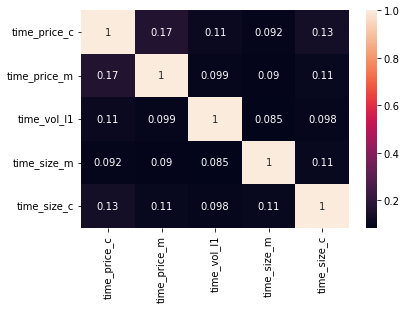

In [12]:
calculate_rank_correraltion(time_id_neighbors)

0         0
1        81
2       110
3        86
4        46
       ... 
1115     83
1116     74
1117     23
1118     17
1119    100
Name: stock_price_l1, Length: 1120, dtype: int64

0         0
1        92
2        59
3        52
4       106
       ... 
1115     83
1116     22
1117    107
1118     33
1119     44
Name: stock_vol_l1, Length: 1120, dtype: int64

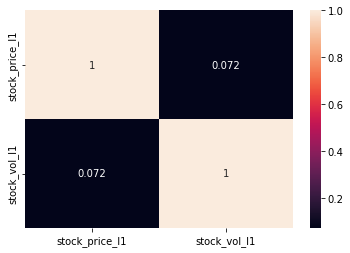

In [13]:
calculate_rank_correraltion(stock_id_neighbors)

#### Aggregate Features With Neighbors

In [30]:
# features with large changes over time are converted to relative ranks within time-id
if ENABLE_RANK_NORMALIZATION:
    df['trade.order_count.mean'] = df.groupby('time_id')['trade.order_count.mean'].rank()
    df['book.total_volume.sum']  = df.groupby('time_id')['book.total_volume.sum'].rank()
    df['book.total_volume.mean'] = df.groupby('time_id')['book.total_volume.mean'].rank()
    df['book.total_volume.std']  = df.groupby('time_id')['book.total_volume.std'].rank()

    df['trade.tau'] = df.groupby('time_id')['trade.tau'].rank()

    for dt in [150, 300, 450]:
        df[f'trade_{dt}.order_count.mean'] = df.groupby('time_id')[f'trade_{dt}.order_count.mean'].rank()
        df[f'book_{dt}.total_volume.sum']  = df.groupby('time_id')[f'book_{dt}.total_volume.sum'].rank()
        df[f'book_{dt}.total_volume.mean'] = df.groupby('time_id')[f'book_{dt}.total_volume.mean'].rank()
        df[f'book_{dt}.total_volume.std']  = df.groupby('time_id')[f'book_{dt}.total_volume.std'].rank()        

In [43]:
time_id_neighbors[0].neighbors.shape

#test_nn.rearrange_feature_values(df2, feature_col)
            
#dst = nn.make_nn_feature(10, np.mean) 

(3833, 80)

In [31]:
def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    print(df2.shape)

    feature_cols_stock = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade_150.tau': [np.mean],
        'book.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
    }
    
    feature_cols = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'real_price': [np.max, np.mean, np.min],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
        'trade_150.tau_nn20_stock_vol_l1_mean': [np.mean],
        'trade.size.sum_nn20_stock_vol_l1_mean': [np.mean],
    }

    time_id_neigbor_sizes = [3, 5, 10, 20, 40]
    time_id_neigbor_sizes_vol = [2, 3, 5, 10, 20, 40]
    stock_id_neighbor_sizes = [10, 20, 40]

    ndf: Optional[pd.DataFrame] = None
    
    # 새로운 feature를 기존 df에 추가하는 함수
    def _add_ndf(ndf: Optional[pd.DataFrame], dst: pd.DataFrame) -> pd.DataFrame:
        if ndf is None:
            return dst
        else:
            ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
            return ndf

    # neighbor stock_id
    for feature_col in feature_cols_stock.keys():
    # 'book.log_return1.realized_volatility', 'trade.seconds_in_bucket.count', 'trade.tau', 'trade_150.tau', 'book.tau', 'trade.size.sum', 'book.seconds_in_bucket.count' 
        try:
            # 해당 특성이 기존 df에 있다면 Pass
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue
            # stock_id_neighbors가 아무것도 없다면 Pass
            if not stock_id_neighbors:
                continue
            
            # stock_id_neighbors의 각 Class (2개)를 반복
            for nn in stock_id_neighbors:
                # stock_id_neighbors에 feature_col로 rearrange_feature_values
                nn.rearrange_feature_values(df2, feature_col)
            
            # agg : feature_cols_stock의 function pointer (np.mean, np.max ...)
            for agg in feature_cols_stock[feature_col]:
                for n in stock_id_neighbor_sizes: # n : [10, 20, 40]
                    try:
                        for nn in stock_id_neighbors:
                            dst = nn.make_nn_feature(n, agg) 
                            # e.g. n : 10, agg : np.mean
                            ndf = _add_ndf(ndf, dst)
                            # add columns
                    except Exception:
                        print_trace('stock-id nn')
                        pass
        except Exception:
            print_trace('stock-id nn')
            pass

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')
    ndf = None

    print(df2.shape)

    # neighbor time_id
    for feature_col in feature_cols.keys():
        try:
            if not USE_PRICE_NN_FEATURES and feature_col == 'real_price':
                continue
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            if 'volatility' in feature_col:
                time_id_ns = time_id_neigbor_sizes_vol
            else:
                time_id_ns = time_id_neigbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('time-id nn')
                        pass
        except Exception:
            print_trace('time-id nn')

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')
    
    print(df2.shape)
    
    # features further derived from nearest neighbor features
    try:
        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes:
                denominator = f"real_price_nn{sz}_time_price_c"

                df2[f'real_price_rankmin_{sz}']  = df2['real_price'] / df2[f"{denominator}_amin"]
                df2[f'real_price_rankmax_{sz}']  = df2['real_price'] / df2[f"{denominator}_amax"]
                df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"{denominator}_mean"]

            for sz in time_id_neigbor_sizes_vol:
                denominator = f"book.log_return1.realized_volatility_nn{sz}_time_price_c"

                df2[f'vol_rankmin_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amin"]
                df2[f'vol_rankmax_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amax"]

        price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
        for c in price_cols:
            del df2[c]

        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes_vol:
                tgt = f'book.log_return1.realized_volatility_nn{sz}_time_price_m_mean'
                df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
    except Exception:
        print_trace('nn features')
    
    print(df2.shape)
    
    return df2

In [32]:
gc.collect()

with timer('make nearest neighbor feature'):
    df2 = make_nearest_neighbor_feature(df)

print(df2.shape)
#df2.reset_index(drop=True).to_feather('optiver_df2.f')

gc.collect()

(428935, 220)
(428935, 280)


C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

(428935, 625)


C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'real_price_rankmin_{sz}']  = df2['real_price'] / df2[f"{denominator}_amin"]
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'real_price_rankmax_{sz}']  = df2['real_price'] / df2[f"{denominator}_amax"]
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually

C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
C:\Users\samsung\AppData\Local\Temp/ipykernel_9888/3909245258.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

(428935, 582)
[make nearest neighbor feature]  70.080초
(428935, 582)


0

In [ ]:
df2.head()

In [35]:
time_id_neighbors[0].feature_values[0].shape # index ,columns ,feature_values ,  feature_col

(3833, 112)

### Misc Features

In [ ]:
# skew correction for NN
cols_to_log = [
    'trade.size.sum',
    'trade_150.size.sum',
    'trade_300.size.sum',
    'trade_450.size.sum',
    'volume_imbalance'
]
for c in df2.columns:
    for check in cols_to_log:
        try:
            if check in c:
                df2[c] = np.log(df2[c]+1)
                break
        except Exception:
            print_trace('log1p')

In [ ]:
# Rolling average of RV for similar trading volume
try:
    df2.sort_values(by=['stock_id', 'book.total_volume.sum'], inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    roll_target = 'book.log_return1.realized_volatility'

    for window_size in [3, 10]:
        df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \
            df2.groupby('stock_id')[roll_target].rolling(window_size, center=True, min_periods=1) \
                                                .mean() \
                                                .reset_index() \
                                                .sort_values(by=['level_1'])[roll_target].values
except Exception:
    print_trace('mean RV')

In [ ]:
# stock-id embedding (helps little)
try:
    lda_n = 3
    lda = LatentDirichletAllocation(n_components=lda_n, random_state=0)

    stock_id_emb = pd.DataFrame(
        lda.fit_transform(pivot.transpose()), 
        index=df_pv.pivot(index='time_id', columns='stock_id', values= 'vol').columns
    )

    for i in range(lda_n):
        df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
except Exception:
    print_trace('LDA')

In [ ]:
df_train = df2[~df2.target.isnull()].copy()
df_test = df2[df2.target.isnull()].copy()
del df2, df_pv
gc.collect()

In [ ]:
df_train.head()

## Reverse Engineering time-id Order & Make CV Split

In [ ]:
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")
    

def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'], engine='pyarrow')
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    return np.argsort(X_compoents[:, 0]), X_compoents


def reconstruct_time_id_order():
    with timer('load files'):
        file_paths = glob.glob('book_train.parquet/**/*.parquet', recursive=True)

        # stock_id 추출 및 열 생성
        df_files = pd.DataFrame({'book_path': file_paths})
        df_files['stock_id'] = df_files['book_path'].str.extractall(r'stock_id=(\d+)').astype(int).reset_index(level=1, drop=True)

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot(index='time_id', columns='stock_id', values= 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)

        clf = TSNE(n_components=1, perplexity=50, random_state=0, init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])
    
    return df_ordered[['time_id']]

In [ ]:
if CV_SPLIT == 'time':
    with timer('calculate order of time-id'):
        if USE_PRECOMPUTE_FEATURES:
            timeid_order = pd.read_csv('time_id_order.csv')
        else:
            timeid_order = reconstruct_time_id_order()
            

    with timer('make folds'):
        timeid_order['time_id_order'] = np.arange(len(timeid_order))
        df_train['time_id_order'] = df_train['time_id'].map(timeid_order.set_index('time_id')['time_id_order'])
        df_train = df_train.sort_values(['time_id_order', 'stock_id']).reset_index(drop=True)

        folds_border = [3830 - 383*4, 3830 - 383*3, 3830 - 383*2, 3830 - 383*1]
        time_id_orders = df_train['time_id_order']

        folds = []
        for i, border in enumerate(folds_border):
            idx_train = np.where(time_id_orders < border)[0]
            idx_valid = np.where((border <= time_id_orders) & (time_id_orders < border + 383))[0]
            folds.append((idx_train, idx_valid))

            print(f"folds{i}: train={len(idx_train)}, valid={len(idx_valid)}")

    del df_train['time_id_order']
elif CV_SPLIT == 'group':
    gkf = GroupKFold(n_splits=4)
    folds = []

    for i, (idx_train, idx_valid) in enumerate(gkf.split(df_train, None, groups=df_train['time_id'])):
        folds.append((idx_train, idx_valid))
else:
    raise ValueError()

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## LightGBM Training

In [ ]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()


def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target', 'tick_size']]
    return df_src[cols]


class EnsembleModel:
    def __init__(self, models: List[lgb.Booster], weights: Optional[List[float]] = None):
        self.models = models
        self.weights = weights

        features = list(self.models[0].feature_name())

        for m in self.models[1:]:
            assert features == list(m.feature_name())

    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            w = self.weights[i] if self.weights is not None else 1
            predicted[:, i] = w * m.predict(x)

        ttl = np.sum(self.weights) if self.weights is not None else len(self.models)
        return np.sum(predicted, axis=1) / ttl

    def feature_name(self) -> List[str]:
        return self.models[0].feature_name()

In [ ]:
df_train

In [ ]:
lr = GBDT_LR
if SHORTCUT_GBDT_IN_1ST_STAGE and IS_1ST_STAGE:
    # to save GPU quota
    lr = 0.3

params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': lr
}

X = get_X(df_train)
y = df_train['target']

X.reset_index(drop=True, inplace=True)
X.to_feather('X.f')


y = df_train[['target']].reset_index(drop=True)
y.to_feather('y.f')

gc.collect()

print(X.shape)
"""
if PREDICT_GBDT:
    ds = lgb.Dataset(X, y, weight=1/np.power(y, 2))

    with timer('lgb.cv'):
        ret = lgb.cv(params, ds, num_boost_round=8000, folds=folds,
             feval=feval_RMSPE, stratified=False,
             return_cvbooster=True, verbose_eval=20,
             early_stopping_rounds=200, seed=42)
# early_stopping_rounds=int(40*0.1/lr))
        print(f"# overall RMSPE: {ret['RMSPE-mean'][-1]}")

    best_iteration = len(ret['RMSPE-mean'])
    for i in range(len(folds)):
        y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[folds[i][1]], num_iteration=best_iteration)
        y_true = y.iloc[folds[i][1]]
        print(f"# fold{i} RMSPE: {rmspe(y_true, y_pred)}")
        
        if i == len(folds) - 1:
            np.save('pred_gbdt.npy', y_pred)

    plot_importance(ret['cvbooster'], figsize=(10, 20))

    boosters = []
    with timer('retraining'):
        for i in range(GBDT_NUM_MODELS):
            params['seed'] = i
            boosters.append(lgb.train(params, ds, num_boost_round=int(1.1*best_iteration)))

    booster = EnsembleModel(boosters)
    del ret
    del ds

gc.collect()
"""

In [ ]:
!pip install torch

In [ ]:
!pip install pytorch-tabnet

## NN Training

In [ ]:
import gc
import os
import random
from typing import List, Tuple, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


null_check_cols = [
    'book.log_return1.realized_volatility',
    'book_150.log_return1.realized_volatility',
    'book_300.log_return1.realized_volatility',
    'book_450.log_return1.realized_volatility',
    'trade.log_return.realized_volatility',
    'trade_150.log_return.realized_volatility',
    'trade_300.log_return.realized_volatility',
    'trade_450.log_return.realized_volatility'
]


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def rmspe_metric(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return rmspe


def rmspe_loss(y_true, y_pred):
    rmspe = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
    return rmspe


class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))

def RMSPELoss_Tabnet(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, x_cat: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx])
        else:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx]), self.y[idx]


class MLP(nn.Module):
    def __init__(self,
                 src_num_dim: int,
                 n_categories: List[int],
                 dropout: float = 0.0,
                 hidden: int = 50,
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 bn: bool = False):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

        if bn:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )
        else:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x_all = torch.cat([x_num, x_cat_emb], 1)
        x = self.sequence(x_all)
        return torch.squeeze(x)


class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,
                 leaky_relu: bool = False):
        super().__init__()

        num_targets = 1

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features + self.cat_dim),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features + self.cat_dim, hidden_size), dim=None),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        if leaky_relu:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0),
                nn.LeakyReLU()
            )
        else:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0)
            )

        self.embs = nn.ModuleList([nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x = torch.cat([x_num, x_cat_emb], 1)

        x = self.expand(x)

        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)


def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = True):
    if na_cols:
        #for c in X.columns:
        for c in null_check_cols:
            if c in X.columns:
                X[f"{c}_isnull"] = X[c].isnull().astype(int)

    cat_cols = [c for c in X.columns if c in ['time_id', 'stock_id']]
    num_cols = [c for c in X.columns if c not in cat_cols]

    X_num = X[num_cols].values.astype(np.float32)
    X_cat = np.nan_to_num(X[cat_cols].values.astype(np.int32))

    def _pca(X_num_):
        if n_pca > 0:
            pca = PCA(n_components=n_pca, random_state=0)
            return pca.fit_transform(X_num)
        return X_num

    if scaler is None:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols, scaler
    else:
        X_num = scaler.transform(X_num) #TODO: infでも大丈夫？
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols


def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x_num.size(0)
        x_num = x_num.to(device, dtype=torch.float)
        x_cat = x_cat.to(device)
        y = y.to(device, dtype=torch.float)

        loss = rmspe_loss(y, model(x_num, x_cat))
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg


def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x_num.size(0)
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                output = model(x_num, x_cat)

            loss = rmspe_loss(y, output)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)

    try:
        metric = rmspe_metric(final_targets, final_outputs)
    except:
        metric = None

    return final_outputs, final_targets, losses.avg, metric


def predict_nn(X: pd.DataFrame,
               model: Union[List[MLP], MLP],
               scaler: StandardScaler,
               device,
               ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    for m in model:
        m.eval()
    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    valid_dataset = TabularDataset(X_num, X_cat, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=512,
                                               shuffle=False,
                                               num_workers=4)

    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat in tqdm(valid_loader, position=0, leave=True, desc='Evaluating'):
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)

            outputs = []
            with torch.no_grad():
                for m in model:
                    output = m(x_num, x_cat)
                    outputs.append(output.detach().cpu().numpy())

            if ensemble_method == 'median':
                pred = np.nanmedian(np.array(outputs), axis=0)
            else:
                pred = np.array(outputs).mean(axis=0)
            final_outputs.append(pred)

    final_outputs = np.concatenate(final_outputs)
    return final_outputs


def predict_tabnet(X: pd.DataFrame,
                   model: Union[List[TabNetRegressor], TabNetRegressor],
                   scaler: StandardScaler,
                   ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    X_processed = np.concatenate([X_cat, X_num], axis=1)

    predicted = []
    for m in model:
        predicted.append(m.predict(X_processed))

    if ensemble_method == 'median':
        pred = np.nanmedian(np.array(predicted), axis=0)
    else:
        pred = np.array(predicted).mean(axis=0)

    return pred


def train_tabnet(X: pd.DataFrame,
                 y: pd.DataFrame,
                 folds: List[Tuple],
                 batch_size: int = 1024,
                 lr: float = 1e-3,
                 model_path: str = 'fold_{}.pth',
                 scaler_type: str = 'standard',
                 output_dir: str = 'artifacts',
                 epochs: int = 250,
                 seed: int = 42,
                 n_pca: int = -1,
                 na_cols: bool = True,
                 patience: int = 10,
                 factor: float = 0.5,
                 gamma: float = 2.0,
                 lambda_sparse: float = 8.0,
                 n_steps: int = 2,
                 scheduler_type: str = 'cosine',
                 n_a: int = 16):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]
        y_tr = y_tr.reshape(-1,1)
        y_va = y_va.reshape(-1,1)
        X_tr = np.concatenate([X_tr_cat, X_tr], axis=1)
        X_va = np.concatenate([X_va_cat, X_va], axis=1)

        cat_idxs = [0]
        cat_dims = [128]

        if scheduler_type == 'cosine':
            scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False)
            scheduler_fn = CosineAnnealingWarmRestarts
        else:
            scheduler_params = {'mode': 'min', 'min_lr': 1e-7, 'patience': patience, 'factor': factor, 'verbose': True}
            scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau

        model = TabNetRegressor(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=1,
            n_d=n_a,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            n_independent=2,
            n_shared=2,
            lambda_sparse=lambda_sparse,
            optimizer_fn=torch.optim.Adam,
            optimizer_params={'lr': lr},
            mask_type="entmax",
            scheduler_fn=scheduler_fn,
            scheduler_params=scheduler_params,
            seed=seed,
            verbose=10
            #device_name=device,
            #clip_value=1.5
        )

        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], max_epochs=epochs, patience=50, batch_size=1024*20,
                  virtual_batch_size=batch_size, num_workers=4, drop_last=False, eval_metric=[RMSPE], loss_fn=RMSPELoss_Tabnet)

        path = os.path.join(output_dir, model_path.format(cv_idx))
        model.save_model(path)

        predicted = model.predict(X_va)

        rmspe = rmspe_metric(y_va, predicted)
        best_losses.append(rmspe)
        best_predictions.append(predicted)

    return best_losses, best_predictions, scaler, model


def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             folds: List[Tuple],
             device,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'mlp',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = -1,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]

        cur_batch = batch_size
        best_loss = 1e10
        best_prediction = None

        print(f"fold {cv_idx} train: {X_tr.shape}, valid: {X_va.shape}")

        train_dataset = TabularDataset(X_tr, X_tr_cat, y_tr)
        valid_dataset = TabularDataset(X_va, X_va_cat, y_va)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True,
                                                   num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch, shuffle=False,
                                                   num_workers=4)

        if model_type == 'mlp':
            model = MLP(X_tr.shape[1],
                        n_categories=[128],
                        dropout=mlp_dropout, hidden=mlp_hidden, emb_dim=emb_dim,
                        dropout_cat=dropout_emb, bn=mlp_bn)
        elif model_type == 'cnn':
            model = CNN(X_tr.shape[1],
                        hidden_size=cnn_hidden,
                        n_categories=[128],
                        emb_dim=emb_dim,
                        dropout_cat=dropout_emb,
                        channel_1=cnn_channel1,
                        channel_2=cnn_channel2,
                        channel_3=cnn_channel3,
                        two_stage=False,
                        kernel1=cnn_kernel1,
                        celu=cnn_celu,
                        dropout_top=cnn_dropout,
                        dropout_mid=cnn_dropout,
                        dropout_bottom=cnn_dropout,
                        weight_norm=cnn_weight_norm,
                        leaky_relu=cnn_leaky_relu)
        else:
            raise NotImplementedError()
        model = model.to(device)

        if optimizer_type == 'adamw':
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError()

        scheduler = epoch_scheduler = None
        if scheduler_type == 'onecycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                            max_lr=max_lr, epochs=epochs,
                                                            steps_per_epoch=len(train_loader))
        elif scheduler_type == 'reduce':
            epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt,
                                                                         mode='min',
                                                                         min_lr=1e-7,
                                                                         patience=patience,
                                                                         verbose=True,
                                                                         factor=factor)

        for epoch in range(epochs):
            if epoch > 0 and epoch % batch_double_freq == 0:
                cur_batch = cur_batch * 2
                print(f'batch: {cur_batch}')
                train_loader = torch.utils.data.DataLoader(train_dataset,
                                                           batch_size=cur_batch,
                                                           shuffle=True,
                                                           num_workers=4)
            train_loss = train_epoch(train_loader, model, opt, scheduler, device)
            predictions, valid_targets, valid_loss, rmspe = evaluate(valid_loader, model, device=device)
            print(f"epoch {epoch}, train loss: {train_loss:.3f}, valid rmspe: {rmspe:.3f}")

            if epoch_scheduler is not None:
                epoch_scheduler.step(rmspe)

            if rmspe < best_loss:
                print(f'new best:{rmspe}')
                best_loss = rmspe
                best_prediction = predictions
                torch.save(model, os.path.join(output_dir, model_path.format(cv_idx)))

        best_predictions.append(best_prediction)
        best_losses.append(best_loss)
        del model, train_dataset, valid_dataset, train_loader, valid_loader, X_tr, X_va, X_tr_cat, X_va_cat, y_tr, y_va, opt
        if scheduler is not None:
            del scheduler
        gc.collect()

    return best_losses, best_predictions, scaler


In [ ]:
!pip install git+https://github.com/dreamquark-ai/tabnet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

del df, df_train
gc.collect()

def get_top_n_models(models, scores, top_n):
    if len(models) <= top_n:
        print('number of models are less than top_n. all models will be used')
        return models
    sorted_ = [(y, x) for y, x in sorted(zip(scores, models), key=lambda pair: pair[0])]
    print(f'scores(sorted): {[y for y, _ in sorted_]}')
    return [x for _, x in sorted_][:top_n]


if PREDICT_MLP:
    model_paths = []
    scores = []
    
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 30
        valid_th = NN_VALID_TH
    
    for i in range(NN_NUM_MODELS):
        # MLP
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               batch_size=512,
                                               mlp_bn=True,
                                               mlp_hidden=256,
                                               mlp_dropout=0.0,
                                               emb_dim=30,
                                               epochs=epochs,
                                               lr=0.002,
                                               max_lr=0.0055,
                                               weight_decay=1e-7,
                                               model_path='mlp_fold_{}' + f"_seed{i}.pth",
                                               seed=i)
        if nn_losses[0] < NN_VALID_TH:
            print(f'model of seed {i} added.')
            scores.append(nn_losses[0])
            model_paths.append(f'artifacts/mlp_fold_0_seed{i}.pth')
            np.save(f'pred_mlp_seed{i}.npy', nn_preds[0])

    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    mlp_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(mlp_model)} models will be used.')
if PREDICT_CNN:
    model_paths = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 50
        valid_th = NN_VALID_TH

    for i in range(NN_NUM_MODELS):
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               cnn_hidden=8*128,
                                               batch_size=1280,
                                               model_type='cnn',
                                               emb_dim=30,
                                               epochs=epochs, #epochs,
                                               cnn_channel1=128,
                                               cnn_channel2=3*128,
                                               cnn_channel3=3*128,
                                               lr=0.00038, #0.0011,
                                               max_lr=0.0013,
                                               weight_decay=6.5e-6,
                                               optimizer_type='adam',
                                               scheduler_type='reduce',
                                               model_path='cnn_fold_{}' + f"_seed{i}.pth",
                                               seed=i,
                                               cnn_dropout=0.0,
                                               cnn_weight_norm=True,
                                               cnn_leaky_relu=False,
                                               patience=8,
                                               factor=0.3)
        if nn_losses[0] < valid_th:
            model_paths.append(f'artifacts/cnn_fold_0_seed{i}.pth')
            scores.append(nn_losses[0])
            np.save(f'pred_cnn_seed{i}.npy', nn_preds[0])
            
    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    cnn_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(cnn_model)} models will be used.')
    
if PREDICT_TABNET:
    tab_model = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 10
        valid_th = 1000
    else:
        print('train full')
        epochs = 250
        valid_th = NN_VALID_TH

    for i in range(TABNET_NUM_MODELS):
        nn_losses, nn_preds, scaler, model = train_tabnet(X, y,  
                                                          [folds[-1]], 
                                                          batch_size=1280,
                                                          epochs=epochs, #epochs,
                                                          lr=0.04,
                                                          patience=50,
                                                          factor=0.5,
                                                          gamma=1.6,
                                                          lambda_sparse=3.55e-6,
                                                          seed=i,
                                                          n_a=36)
        if nn_losses[0] < valid_th:
            tab_model.append(model)
            scores.append(nn_losses[0])
            np.save(f'pred_tab_seed{i}.npy', nn_preds[0])
            model.save_model(f'artifacts/tabnet_fold_0_seed{i}')
            
    tab_model = get_top_n_models(tab_model, scores, TAB_MODEL_TOP_N)
    print(f'total {len(tab_model)} models will be used.')

In [ ]:
del X, y
gc.collect()

## Inference

In [ ]:
X_test = get_X(df_test)
print(X_test.shape)

In [ ]:
df_pred = pd.DataFrame()
df_pred['row_id'] = df_test['stock_id'].astype(str) + '-' + df_test['time_id'].astype(str)

predictions = {}

prediction_weights = {}

if PREDICT_GBDT:
    gbdt_preds = booster.predict(X_test)
    predictions['gbdt'] = gbdt_preds
    prediction_weights['gbdt'] = 4


if PREDICT_MLP and mlp_model:
    try:
        mlp_preds = predict_nn(X_test, mlp_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'mlp: {mlp_preds.shape}')
        predictions['mlp'] = mlp_preds
        prediction_weights['mlp'] = 1
    except:
        print(f'failed to predict mlp: {traceback.format_exc()}')


if PREDICT_CNN and cnn_model:
    try:
        cnn_preds = predict_nn(X_test, cnn_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'cnn: {cnn_preds.shape}')
        predictions['cnn'] = cnn_preds
        prediction_weights['cnn'] = 4
    except:
        print(f'failed to predict cnn: {traceback.format_exc()}')


if PREDICT_TABNET and tab_model:
    try:
        tab_preds = predict_tabnet(X_test, tab_model, scaler, ensemble_method=ENSEMBLE_METHOD).flatten()
        print(f'tab: {tab_preds.shape}')
        predictions['tab'] = tab_preds
        prediction_weights['tab'] = 1
    except:
        print(f'failed to predict tab: {traceback.format_exc()}')

        
overall_preds = None
overall_weight = np.sum(list(prediction_weights.values()))

print(f'prediction will be made by: {list(prediction_weights.keys())}')

for name, preds in predictions.items():
    w = prediction_weights[name] / overall_weight
    if overall_preds is None:
        overall_preds = preds * w
    else:
        overall_preds += preds * w
        
df_pred['target'] = np.clip(overall_preds, 0, None)


In [ ]:
sub = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'sample_submission.csv'))
submission = pd.merge(sub[['row_id']], df_pred[['row_id', 'target']], how='left')
submission['target'] = submission['target'].fillna(0)
submission.to_csv('submission.csv', index=False)